# 0. DATA620: Final Project Proposal - Federal Reserve Sentiment

## Homework Team 3: David Simbandumwe, Eric Lehmphul and Lidiia Tronina

Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters. 

# Setup

## Import Modules

In [21]:
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from textblob import Word

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import spacy
import spacy.cli
from spacy.lang.en import English

from textatistic import Textatistic
from wordcloud import WordCloud
import statsmodels.api as sm

import networkx as nx
import warnings
from scipy.stats import ttest_ind
plt.rcParams.update({'axes.facecolor':'orange'})

## Global Settings

In [22]:
random.seed(123)

## Global Functions

In [23]:
# Function that returns average word length
def avg_word_length(x):
    # Split the string into words
    words = x.split()
    # Compute length of each word and store in a separate list
    word_lengths = [len(word) for word in words]
    # Compute average word length
    avg_word_length = sum(word_lengths)/len(words)
    # Return average word length
    return(avg_word_length)


def filter_propn(s):
    
    stopwords = spacy.lang.en.stop_words.STOP_WORDS
    
    
    # Load model and create Doc object
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(s)

    # Generate lemmatized tokens
    lemmas = [token.lemma_ for token in doc]

    # Remove stopwords and non-alphabetic tokens
    a_lemmas = [lemma for lemma in lemmas 
                if lemma.isalpha() and lemma not in stopwords]

    a_lemmas = ' '.join(a_lemmas)
    doc_lemmas = nlp(a_lemmas)

    # Generate list of tokens and pos tags
    pos = [(token.text, token.pos_) for token in doc_lemmas]
    
    l = list(zip(*pos))[0]
    l = sorted(set(l))
    
    return ' '.join(l)


def get_city_name(n):
    nlp = spacy.load('en_core_web_sm')

    doc = nlp(n)
    places = [str(ent) for ent in doc.ents if ent.label_ in ['GPE', 'LOC']]

    return ' '.join(places)
   

<br>

# 1. Introduction

<br><br>

## Hypothesis

In the time leading up FOMC Meeting the Fed Chair and the Governors of the 12 Federal Reserve Banks will develop an economic outlook that will inform their vote at the FOMC Meeting. One way to measure transparency is to evaluate how well this economic outlook is communicated to the general public through speeches. Fortunately for this analysis the Fed tracks all speeches by it board of governors and posts them to www.federalreserve.gov with transcripts.

For this analysis we can categorize the periods between FOMC meeting by their outcome. In each meeting the interest rate target will either be increased, decreased or remain the same. For each type of FOMC meeting outcome we would like to understand if the communication by the representatives of the Fed is consistent and predictable. 

- H0 - Communications by Federal Reserve Chair do not telegraph the outcome of the upcoming FOMC Meeting. There is no decipherable difference in speeches by Fed Chair during periods of increase, decreasing or stable interest rates. 

- H1 - Federal Reserve Chair will telegraph the outcome of the upcoming FOMC Meeting through their communications. The speeches by Fed Chair will differ predictably during periods of increase, decreasing or stable interest rates.  

# 2. Workflow

## Obtain

<br>

### Data Source
There are several sources of prepossessed data from the Fed Reserve speeches and FOMC Meeting outcomes, however it might be necessary to augment these data set to get the latest information. For the purposes of this analysis we will create two unique data sets. 

1. Aggregate FOMC Decisions - the outcome of each FOMC meeting is captured in a broader write-up however the decision can be distilled into meeting date, meeting location, decision to increase, decrease or leave interested unchanged, and a magnitude of the change, and the new target range for interest rates
2. Aggregate Speeches by FOMC Members - Each member of the FOMC maintains a detailed calendar of speeches that includes, location, audience, speech title, speech text.

The ability to forecast result of an FOMC meeting can generate significant financial gains as a result there is a large body of work analyzing the topic, using a variety of methods. 

<br>

### FOMC Fed Rate Decision (events)

The Federal Open Market Committee meets a minimum of 8 times a year in regularly scheduled sessions. During these sessions the representatives from the Federal Reserve member banks will discuss their economic outlook. At the conclusion of each meeting the member of FOMC will reach consensus on a monetary policy decision. The data set below captures the result of the FOMC meetings since May 1987.

In [24]:
# load FOMC decision
decision_df = pd.read_csv('data/Manual_Event.csv')

<br><br>

### Federal Reserve Chairman Communications (speeches)

The speeches by the Federal Reserve Chair are captured in the following dataframe. The data set is fitered down to speeches by Fed Chairs including Alan Greenspan, Ben S. Bernanke, Janet L. Yellen, Jerome H. Powell. The data set is also cleaned up for stop words and custom stop words.

In [25]:
# load speeches
speech_df = pd.read_csv('data/fed_speeches_1996_2020.csv', parse_dates=['speech_date'] , encoding='utf_8')

## Scrub

<br>

### FOMC Fed Rate Decision (events)

In [26]:
decision_df['event_date']  = pd.to_datetime(decision_df['event_date'])
decision_df['date_diff'] = decision_df['event_date'].diff()
decision_df['start_date'] = decision_df['event_date'] - decision_df['date_diff']
decision_df['end_date'] = decision_df['event_date']
decision_df['event_id'] = 'E' + decision_df.index.astype(str)
decision_df = decision_df.drop(['id'], axis=1)
decision_df.head()

,event_date,fed_rate,action,rate_change,fed_chair,notes,date_diff,start_date,end_date,event_id
0,1987-05-19,0.0650,increase,0.0062,Paul Volcker,Continued raising rates to fight inflation,NaT,NaT,1987-05-19,E0
1,1987-07-07,0.0650,no change,0.0000,Alan Greenspan,- no change -,49 days,1987-05-19,1987-07-07,E1
2,1987-08-18,0.0650,no change,0.0000,Alan Greenspan,- no change -,42 days,1987-07-07,1987-08-18,E2
3,1987-09-22,0.0725,increase,0.0075,Alan Greenspan,No notable event,35 days,1987-08-18,1987-09-22,E3
4,1987-11-04,0.0681,decrease,-0.0044,Alan Greenspan,Lowered after Black Monday stock market crash,43 days,1987-09-22,1987-11-04,E4


<br>

### Federal Reserve Chairman Communications (speeches)

In [27]:
# filter out some garbage records
speech_df = speech_df[speech_df['text_len'] > 50]
speech_df['year'] = speech_df['year'].astype(int)

# filter by Fed Chair
#list_of_values = ['Chairman Alan Greenspan','Chairman Ben S. Bernanke','Chair Janet L. Yellen','Chairman Jerome H. Powell']
#speech_df = speech_df[speech_df['speaker'].isin(list_of_values)]
speech_df['speaker'].value_counts(sort=True)

Chairman Alan Greenspan                         183
Chairman Ben S. Bernanke                        169
Vice Chairman Roger W. Ferguson                  96
Governor Susan S. Bies                           77
Governor Lael Brainard                           68
Governor Laurence H. Meyer                       65
Governor Edward M. Gramlich                      59
Governor Daniel K. Tarullo                       54
Governor Jerome H. Powell                        50
Vice Chairman Donald L. Kohn                     46
Governor Mark W. Olson                           46
Vice Chairman Stanley Fischer                    45
Governor Ben S. Bernanke                         45
Governor Randall S. Kroszner                     44
Governor Elizabeth A. Duke                       44
Chair Janet L. Yellen                            44
Vice Chair for Supervision Randal K. Quarles     39
Chairman Jerome H. Powell                        32
Governor Donald L. Kohn                          30
Governor Rog

In [28]:
# remove stop words from text
stop_words = set(stopwords.words('english')) 
custom_stopwords = set(('chairman','chair','alan','greenspan','ben','bernanke','janet', 'yellen','jerome','powell',',',' ','.', ';', '?', '-', '!', '(', ')','--','"',"'", ':', '¡¦', '¡','', '9', '/'))

# process text
speech_df['speech_id'] = 'S' + speech_df.index.astype(str)
speech_df['text'] = speech_df['text'].str.lower()
speech_df['text'] = speech_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom_stopwords)]))
speech_df['filter_text'] = speech_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
speech_df['filter_text'] = speech_df['filter_text'].apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))
speech_df['filter_text_len'] = speech_df['filter_text'].apply(lambda x: len(x.split()))
speech_df['avg_word_length_filter'] = speech_df['filter_text'].apply(avg_word_length)
speech_df.head()

,link,title,speaker,event,year,text,speech_date,text_len,location,speech_id,filter_text,filter_text_len,avg_word_length_filter
0,https://www.federalreserve.gov/boarddocs/speec...,Supervision of bank risk-taking,Vice Chair Alice M. Rivlin,At the The Brookings Institution National Issu...,1996,i discovered when i joined the board of govern...,1996-12-19,3671,D.C.,S0,discovered joined board governor federal reser...,2092,7.125717
1,https://www.federalreserve.gov/boarddocs/speec...,Social security,Chairman Alan Greenspan,At the Abraham Lincoln Award Ceremony of the U...,1996,i am privileged to accept the union league of ...,1996-12-06,2596,Pennsylvania,S1,privileged accept union league philadelphia's ...,1551,6.969697
2,https://www.federalreserve.gov/boarddocs/speec...,The challenge of central banking in a democrat...,Chairman Alan Greenspan,At the Annual Dinner and Francis Boyer Lecture...,1996,the challenge of central banking in a democrat...,1996-12-05,4344,D.C.,S2,challenge central banking democratic society g...,2379,7.200504
3,https://www.federalreserve.gov/boarddocs/speec...,Clearinghouses and risk management,"Governor Edward W. Kelley, Jr.","At the 1996 Payments System Risk Conference, W...",1996,it is a pleasure to be with you this morning t...,1996-12-03,2527,D.C.,S3,pleasure morning discus private-sector payment...,1488,7.305780
4,https://www.federalreserve.gov/boarddocs/speec...,Supervisory and regulatory responses to financ...,Governor Susan M. Phillips,At the BAI Seminar on Regulatory Policy Change...,1996,supervisory and regulatory responses to financ...,1996-11-25,2222,D.C.,S4,supervisory regulatory response financial inno...,1281,7.597970


<br>

### merge speech and FOMC Meeting (events)

By merging the event and the speech data frames we can associate each speech with a period and FOMC action.

In [29]:
df_merge = decision_df.merge(speech_df, how='cross')
df_merge = df_merge.query('speech_date > start_date and speech_date <= end_date')
df_merge.head(5)

,event_date,fed_rate,action,rate_change,fed_chair,notes,date_diff,start_date,end_date,event_id,...,event,year,text,speech_date,text_len,location,speech_id,filter_text,filter_text_len,avg_word_length_filter
121649,1996-07-03,0.0525,no change,0.0,Alan Greenspan,- no change -,43 days,1996-05-21,1996-07-03,E84,...,"At the CyberPayments '96 Conference, Dallas, T...",1996,"remarks by governor edward w. kelley, jr. deve...",1996-06-18,2635,Texas,S17,"remark governor edward w. kelley, jr. developm...",1536,7.205078
121650,1996-07-03,0.0525,no change,0.0,Alan Greenspan,- no change -,43 days,1996-05-21,1996-07-03,E84,...,At the International Conference of Banking Sup...,1996,remarks by bank supervision in a world economy...,1996-06-13,3164,Sweden,S18,remark bank supervision world economy internat...,1837,7.357104
124543,1996-09-24,0.0525,no change,0.0,Alan Greenspan,- no change -,35 days,1996-08-20,1996-09-24,E86,...,At the U.S. Treasury Conference on Electronic ...,1996,remarks by regulation of electronic payment sy...,1996-09-19,1948,D.C.,S15,remark regulation electronic payment system u....,1132,7.118375
124544,1996-09-24,0.0525,no change,0.0,Alan Greenspan,- no change -,35 days,1996-08-20,1996-09-24,E86,...,At the National Association of Business Econom...,1996,monetary policy objectives and strategy i want...,1996-09-08,2633,Massachusetts,S16,monetary policy objective strategy want share ...,1441,6.927828
125983,1996-11-13,0.0525,no change,0.0,Alan Greenspan,- no change -,50 days,1996-09-24,1996-11-13,E87,...,"At the BAI Money Transfer '96 Conference, New ...",1996,the future of electronic payments i am delight...,1996-10-31,2449,New York,S7,future electronic payment delighted morning di...,1423,6.907238


## Explore

<br>

### FOMC Fed Rate Decision (events)

In [30]:
decision_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   event_date   302 non-null    datetime64[ns] 
 1   fed_rate     302 non-null    float64        
 2   action       302 non-null    object         
 3   rate_change  302 non-null    float64        
 4   fed_chair    302 non-null    object         
 5   notes        302 non-null    object         
 6   date_diff    301 non-null    timedelta64[ns]
 7   start_date   301 non-null    datetime64[ns] 
 8   end_date     302 non-null    datetime64[ns] 
 9   event_id     302 non-null    object         
dtypes: datetime64[ns](3), float64(2), object(4), timedelta64[ns](1)
memory usage: 23.7+ KB


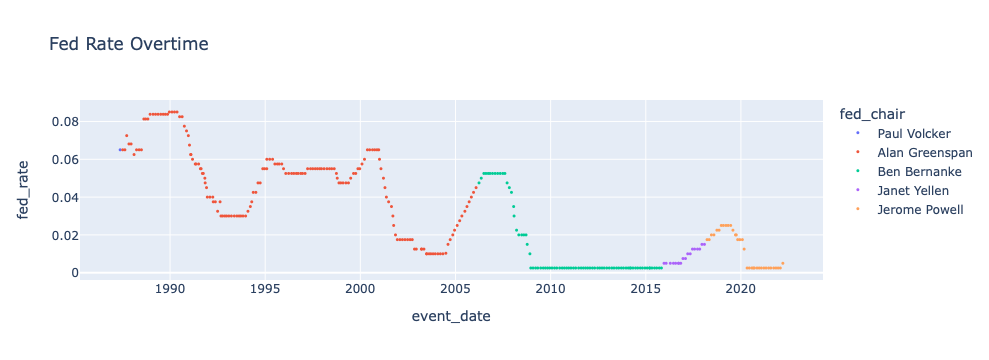

In [31]:
fig = px.scatter(data_frame=decision_df, 
                x='event_date', y='fed_rate', 
                color="fed_chair", 
                title='Fed Rate Overtime',
            )

fig.update_traces(marker_size=3)

fig.show()

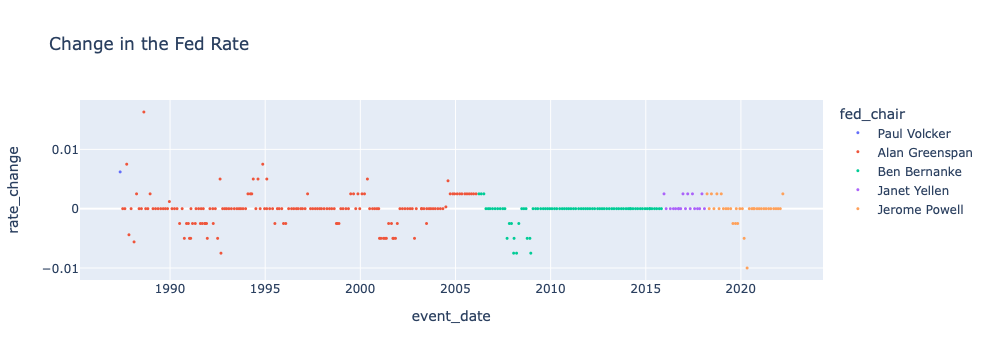

In [32]:
fig = px.scatter(data_frame=decision_df, 
                x='event_date', y='rate_change', 
                color="fed_chair", 
                title='Change in the Fed Rate',   
            )

fig.update_traces(marker_size=3)

fig.show()

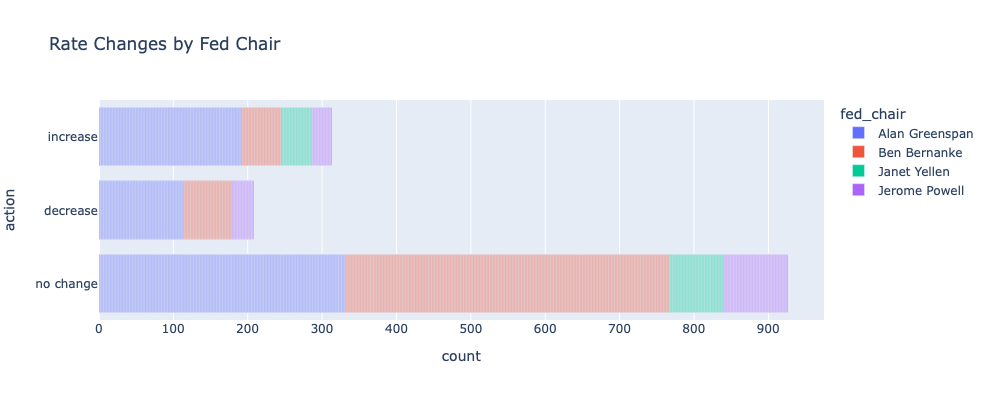

In [33]:
fig = px.bar(df_merge, y="action", color='fed_chair', orientation='h',
             hover_data=["action", "rate_change"],
             height=400,
             title='Rate Changes by Fed Chair')
fig.show()

<br>

### Federal Reserve Chairman Communications (speeches)

In [34]:
speech_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448 entries, 0 to 1455
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   link                    1448 non-null   object        
 1   title                   1448 non-null   object        
 2   speaker                 1446 non-null   object        
 3   event                   1448 non-null   object        
 4   year                    1448 non-null   int64         
 5   text                    1448 non-null   object        
 6   speech_date             1447 non-null   datetime64[ns]
 7   text_len                1448 non-null   int64         
 8   location                1448 non-null   object        
 9   speech_id               1448 non-null   object        
 10  filter_text             1448 non-null   object        
 11  filter_text_len         1448 non-null   int64         
 12  avg_word_length_filter  1448 non-null   float64 

In [35]:
fig = px.histogram(df_merge, x="text_len", marginal="rug", color='speaker', nbins=150, hover_data=['speaker','title']
                  ,title="Length of Speach")
fig.show()

KeyError: (nan, '', '', '', '')

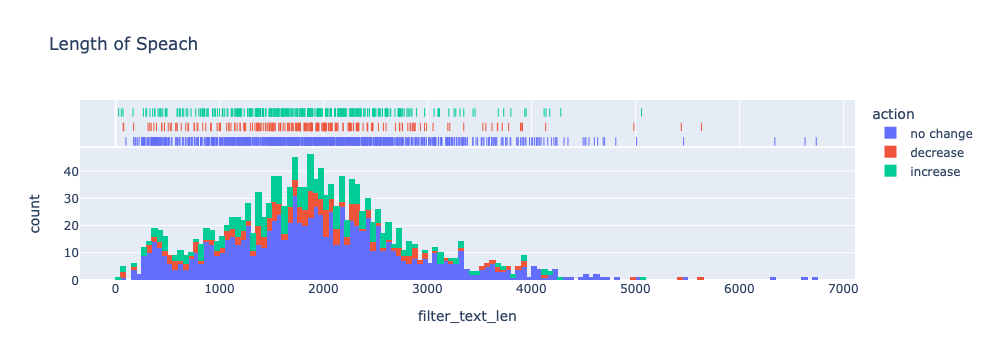

In [36]:
fig = px.histogram(df_merge, x="filter_text_len", color='action' ,marginal="rug",nbins=150, hover_data=['speaker','title']
                  ,title="Length of Speach")
fig.show()

In [ ]:
text = str(df_merge['text'])
title = 'Speech WordCloud - All Text'

w = text.split()

words = ' '.join(w)

wordcloud = WordCloud(
                  background_color='white',
                  width=5000,
                  height=3000
                 ).generate(words)
plt.figure(1,figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title(title, fontsize=24)
plt.show()

In [ ]:
text = str(df_merge['filter_text'])
title = 'Speech WordCloud - Filtered Words'

w = text.split()

words = ' '.join(w)

wordcloud = WordCloud(
                  background_color='white',
                  width=5000,
                  height=3000
                 ).generate(words)
plt.figure(1,figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title(title, fontsize=24)
plt.show()

<br>

### merge speech and FOMC Meeting (events)

## Model

### Predict FOMC Rate Decision (Naive Bayes Sentiment Analysis)

In [ ]:
set(df_merge['speaker'])

#### Chairman Alan Greenspan

In [ ]:
df_merge.columns

In [ ]:
set(df_merge['fed_chair'])

In [ ]:
df_merge['fed_chair'].value_counts(sort=True)

In [ ]:
greenspan_df = df_merge[df_merge['speaker'] == 'Chairman Alan Greenspan']

In [ ]:
fig = px.bar(greenspan_df, y="action", color='rate_change', orientation='h',
             hover_data=["action", "rate_change"],
             height=400,
             title='Rate Changes by Fed Chair (Alan Greenspan)')
fig.show()

In [ ]:
# Create CountVectorizer object
vectorizer = CountVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)

# Split into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(greenspan_df['filter_text'], greenspan_df['action'], test_size=0.25)
X_train, X_test, y_train, y_test = train_test_split(greenspan_df['filter_text'], greenspan_df['rate_change'].astype(str), test_size=0.25)

In [ ]:
# Generate training Bow vectors
X_train_bow = vectorizer.fit_transform(X_train)

# Generate test BoW vectors
X_test_bow = vectorizer.transform(X_test)

In [ ]:
# Create MultinomialNB object
clf = MultinomialNB()

# Train clf
clf.fit(X_train_bow, y_train)
cv_results = cross_val_score(clf, X_train_bow, y_train, cv=5)

In [ ]:
print(cv_results)

In [ ]:
print("Average 5-Fold CV Score: {}".format(np.mean(cv_results)))

In [ ]:
# confusion matrix
y_pred = clf.predict(X_test_bow)
cm = confusion_matrix(y_test, y_pred)
#print(cm)

#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [ ]:
print(classification_report(y_test, y_pred))

#### Chairman Ben S. Bernanke

In [ ]:
ben_df = df_merge[df_merge['speaker'] == 'Chairman Ben S. Bernanke']

In [ ]:
fig = px.bar(ben_df, y="action", color='rate_change', orientation='h',
             hover_data=["action", "rate_change"],
             height=400,
             title='Rate Changes by Fed Chair (Ben Bernanke)')
fig.show()

In [ ]:
# Create CountVectorizer object
vectorizer = CountVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(ben_df['filter_text'], ben_df['action'], test_size=0.25)
#X_train, X_test, y_train, y_test = train_test_split(ben_df['filter_text'], ben_df['rate_change'].astype(str), test_size=0.25)

In [ ]:
# Generate training Bow vectors
X_train_bow = vectorizer.fit_transform(X_train)

# Generate test BoW vectors
X_test_bow = vectorizer.transform(X_test)

In [ ]:
# Create MultinomialNB object
clf = MultinomialNB()

# Train clf
clf.fit(X_train_bow, y_train)
cv_results = cross_val_score(clf, X_train_bow, y_train, cv=5)

In [ ]:
print(cv_results)

In [ ]:
print("Average 5-Fold CV Score: {}".format(np.mean(cv_results)))

In [ ]:
# confusion matrix
y_pred = clf.predict(X_test_bow)
cm = confusion_matrix(y_test, y_pred)
#print(cm)

#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [ ]:
print(classification_report(y_test, y_pred))

#### Chair Janet L. Yellen

In [ ]:
yellen_df = df_merge[df_merge['speaker'] == 'Chair Janet L. Yellen']

In [ ]:
fig = px.bar(yellen_df, y="action", color='rate_change', orientation='h',
             hover_data=["action", "rate_change"],
             height=400,
             title='Rate Changes by Fed Chair (Janet L. Yellen)')
fig.show()

In [ ]:
#### Chairman Jerome H. Powell

In [ ]:
powell_df = df_merge[df_merge['speaker'] == 'Chairman Jerome H. Powell']

In [ ]:
fig = px.bar(powell_df, y="action", color='rate_change', orientation='h',
             hover_data=["action", "rate_change"],
             height=400,
             title='Rate Changes by Fed Chair (Jerome H. Powell)')
fig.show()

### Predict FOMC Rate Decision (Naive Bayes Sentiment Analysis)

# confusion matrix
y_pred = clf.predict(X_test_bow)
cm = confusion_matrix(y_test, y_pred)
#print(cm)

#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [ ]:
n_a = 28/len(y_test)

print('A Naive model that always predicts no change would be accurate: ',round(n_a,4))

## iNterpret

# 3. Conclusion